## Setup

In [1]:
from evaluate import *
import pandas as pd
from sklearn.model_selection import LeaveOneOut
import warnings
from collections import Counter, defaultdict
from itertools import combinations
import os
import pickle

In [2]:
data_root = r'RSRM\data\SR\\'

In [3]:
dataset='alestrus'
regression = True if dataset == 's' else False
tt = 'loo_mae' if regression else 'loo_tss'
cv_info = f'Treated results/{dataset}_folds.txt'
linear_cv_data = f'Treated results/linear_{dataset}_cross_validation.csv'
pysr_cv_data = f'Treated results/pysr_{dataset}_cross_validation.csv'
rsrm_cv_data = f'Treated results/rsrm_{dataset}_cross_validation.csv'
data_file = f'{dataset}'

In [4]:
folds = read_train_test_indices(cv_info)
dataset_name = {'lepthyphantes': 'canariphantes', 'alestrus': 'alestrus', 's': 'species richness'}[dataset]
dataset_name = dataset_name.capitalize()
if regression:
    metric = 'Pseudo R²'
else:
    metric = 'TSS'
linear_df_o = pd.read_csv(linear_cv_data)
linear_df_o['Equation'] = linear_df_o['Equation'].apply(remove_sigmoid)
pysr_df_o = pd.read_csv(pysr_cv_data)
rsrm_df_o = pd.read_csv(rsrm_cv_data)
X1, y1 = load_dataset(data_root + data_file + '_train.csv')
X2, y2 = load_dataset(data_root + data_file + '_test.csv')
X = pd.concat([X1, X2], ignore_index=True) 
y = pd.concat([y1, y2], ignore_index=True).astype(int)
get_fold = get_fold_wrapper(X, y, folds)
originals = {'linear': linear_df_o, 'pysr': pysr_df_o, 'rsrm': rsrm_df_o}

In [5]:
linear_df = pd.DataFrame(columns=['run', 'equation', 'complexity', 'train', 'test'])
pysr_df = pd.DataFrame(columns=['run', 'equation', 'complexity', 'train', 'test'])
rsrm_df = pd.DataFrame(columns=['run', 'equation', 'complexity', 'train', 'test'])
new_ones = {'linear': linear_df, 'pysr': pysr_df, 'rsrm': rsrm_df}
predictions = {}
for key in originals.keys():
    new_df = new_ones[key]
    original_df = originals[key]
    new_df['skeleton'] = original_df['Equation'].apply(replace_numeric_parameters)
    new_df['run'] = original_df['Run']
    new_df['complexity'] = original_df['Equation'].apply(count_weighted_operations)
    new_df.drop(new_df[new_df['complexity'] == 0].index, inplace=True)
    new_df.drop(new_df[new_df['complexity'] > 20].index, inplace=True)
    new_df['train'] = original_df[f'{metric} (train)'].astype(float)
    new_df['test'] = original_df[f'{metric} (test)'].astype(float)
    new_df['equation'] = original_df['Equation']
    new_df['lambda'] = lambdify_equations(new_df['equation'], X.columns.tolist())
    # if not regression:
        # for run in range(1, new_df['run'].nunique() + 1):
            # X_train, y_train, X_test, y_test = get_fold(run)
            # rows =  new_df[new_df['run'] == run]
            # thresholds = rows['lambda'].apply(lambda func: get_threshold(func, X_train, y_train))
            # new_df.loc[new_df['run'] == run, 'thresholds'] = thresholds.round(3)

### Run

In [6]:
# Define regression settings
warnings.filterwarnings("ignore", category=RuntimeWarning)
if regression:
    loss = 'poisson'
    metric = mae
    metric_name = 'mae'
else:
    loss = 'bce'
    metric = true_skill_statistic
    metric_name = 'tss'

#### Alestrus

In [7]:
# Create a directory to save the files
output_dir = "saved_data"
os.makedirs(output_dir, exist_ok=True)
params_filename = os.path.join(output_dir, f"parameters_{dataset}.pkl")
# Initialize a dictionary to store parameters (Cs)
parameters_dict = {}
precomputed = defaultdict(bool)

# Iterate over the keys in originals
for key in originals.keys():
    df_filename = os.path.join(output_dir, f"{dataset}_{key}_dataframe.csv")

    if os.path.exists(df_filename):
        print(f"Loading precomputed data for {key}...")
        globals()[f'{key}_df'] = pd.read_csv(df_filename)
        new_ones[key] = globals()[f'{key}_df']
    else:
        if os.path.exists(params_filename):
            with open(params_filename, "rb") as f:
                parameters_dict = pickle.load(f)
            print(f"Loaded parameters from {params_filename}")
        else:
            print(f"Computing data for {key}...")
        use_glm = (key == 'linear')
        new_df = new_ones[key]
        scores = []

        for eq_str in new_df['equation']:
            equation = BernoulliEquation(eq_str, X.columns.tolist(), use_glm=use_glm)
            params_dict_key = equation.skeleton
            all_targets, all_predictions, all_params, used_precomputed = loocv(equation, X, y, prefitted_params=parameters_dict.get(params_dict_key, None)) 
            parameters_dict[params_dict_key] = all_params
            precomputed[params_dict_key] = used_precomputed
            scores.append(metric(all_targets, all_predictions))

        # Add scores to the DataFrame
        new_ones[key][f'loo_{metric_name}'] = scores
        # Print results for this key
        print(f"Results for {key}:")
        print(scores)

        # Save the DataFrame to disk
        df_tosave = new_df.drop(columns=['lambda'])
        df_tosave.to_csv(df_filename, index=False)
        print(f"Saved DataFrame for {key} to {df_filename}")

# Save parameters
with open(params_filename, "wb") as f:
    pickle.dump(parameters_dict, f)
print(f"Saved parameters to {params_filename}")
print("Used precomputed: ", all(precomputed.values()))

Loaded parameters from saved_data\parameters_alestrus.pkl
Results for linear:
[0.3148936170212766, 0.5574468085106383, 0.5787234042553191, 0.5361702127659576, 0.7148936170212767, 0.3148936170212766, 0.5574468085106383, 0.9361702127659575, 0.7574468085106383, 0.7148936170212767, 0.3148936170212766, 0.5574468085106383, 0.5787234042553191, 0.7361702127659575, 0.7148936170212767, 0.3148936170212766, 0.5574468085106383, 0.7574468085106383, 0.7361702127659575, 0.7148936170212767, 0.3148936170212766, 0.5574468085106383, 0.5787234042553191, 0.7361702127659575, 0.7148936170212767]
Saved DataFrame for linear to saved_data\alestrus_linear_dataframe.csv
Loaded parameters from saved_data\parameters_alestrus.pkl
Results for pysr:
[0.0, 0.3148936170212766, 0.8085106382978724, -0.06382978723404253, 0.672340425531915, -0.8, 0.40851063829787226, -0.8, 0.40851063829787226, 0.40851063829787226, 0.3148936170212766, 0.451063829787234, 0.0, 0.3148936170212766, 0.8085106382978724, -0.004255319148936176, 0.557

In [9]:
from collections import Counter
from itertools import combinations
import pandas as pd

counts_dict = {}

for key in originals.keys():
    new_df = new_ones[key]
    eqs_per_run = new_df.groupby('run')['skeleton'].agg(set)
    counts = Counter([item for subset in eqs_per_run for item in subset])
    counts_dict[key] = counts  # Store the Counter in the dictionary
    new_df['count'] = [counts_dict[key][s] for s in new_df['skeleton']]

    # Filter elements with count > 1 and create a DataFrame
    filtered_elements = [(el, c) for el, c in counts.items() if c > 1]
    results_df = pd.DataFrame(filtered_elements, columns=['element', 'count']).sort_values('count', ascending=False)
    results_df[f'{tt}'] = results_df['element'].apply(lambda eq: new_df[new_df['skeleton'] == eq][f'{tt}'].min())
    print(f"Results for {key}:")
    print(results_df)

# Sum all Counters in the dictionary
all_counts = sum(counts_dict.values(), Counter())

# Filter elements with count > 1 in the aggregated Counter
filtered_elements = [(el, c) for el, c in all_counts.items() if c > 1]
print("Aggregated results:")
filtered_show_df = pd.DataFrame(filtered_elements, columns=['skeleton', 'count']).sort_values('count', ascending=False)
print(filtered_show_df)

# Find pairwise intersections (including keys)
pairwise_intersections = [
    (key1, key2, set(counter1.keys()) & set(counter2.keys()))
    for (key1, counter1), (key2, counter2) in combinations(counts_dict.items(), 2)
]

# Print pairwise intersections with keys
print("Pairwise intersections:")
for key1, key2, common_elements in pairwise_intersections:
    print(f"Pairwise interactions between {key1}, {key2}: {common_elements}")

Results for linear:
                            element  count   loo_tss
0                           C - C*D      5  0.314894
1                     C*H - C*P - C      5  0.557447
2  C*D + C*H - C*P - C*Sl + C*T - C      2  0.714894
3              C*H - C*P - C*Sl - C      2  0.578723
4        C*D - C*P - C*Sl - C*T + C      2  0.736170
5  C*D - C*H - C*P - C*Sl - C*T + C      2  0.714894
Results for pysr:
                           element  count   loo_tss
1                                C      5  0.000000
7                   cond(C - H, C)      5  0.808511
0                              C*D      4  0.314894
3          cond(C - H, C) + inv(P)      3  0.672340
4      cond(C - H, C) + inv(C - P)      3  0.408511
2  cond(C - H, C) + inv(C*H - C*P)      2  0.314894
5    cond(C - H, C) + inv(C*H - P)      2  0.408511
6               cond(C - H, C) + C      2 -0.063830
8               D + cond(C - H, C)      2  0.357447
Results for rsrm:
         element  count   loo_tss
1              C   

## Thresholds

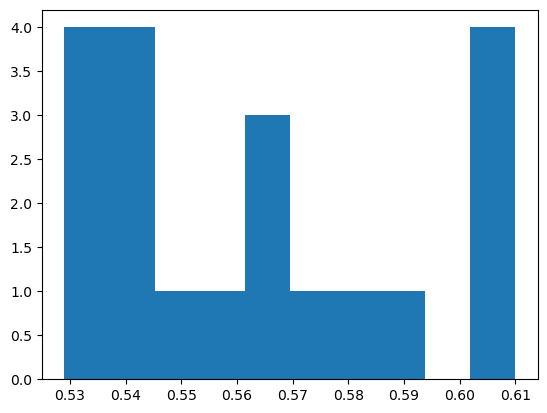

In [6]:
# Canariphantes
plt.hist(linear_df['thresholds'], bins=10)
plt.show()

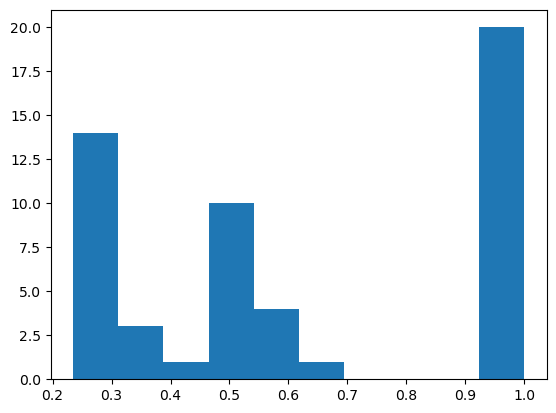

In [7]:
# Canariphantes
plt.hist(pysr_df['thresholds'], bins=10)
plt.show()

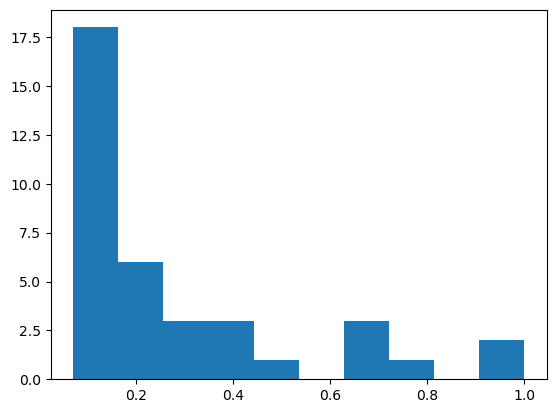

In [8]:
# Canariphantes
plt.hist(rsrm_df['thresholds'], bins=10)
plt.show()

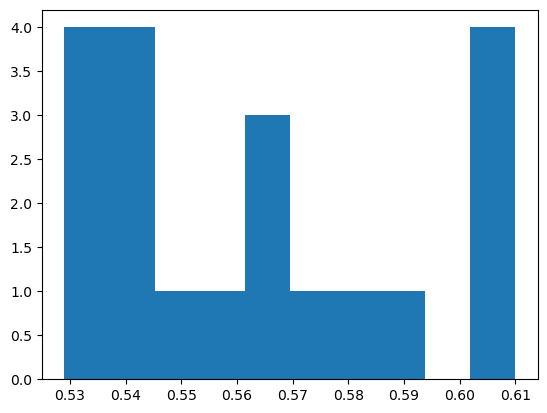

In [9]:
# Alestrus
plt.hist(linear_df['thresholds'], bins=10)
plt.show()

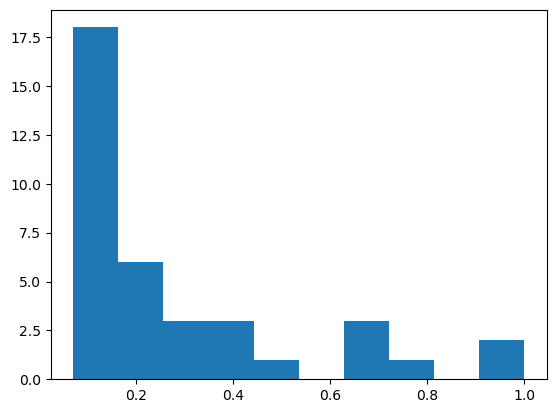

In [10]:
# Alestrus
plt.hist(rsrm_df['thresholds'], bins=10)
plt.show()

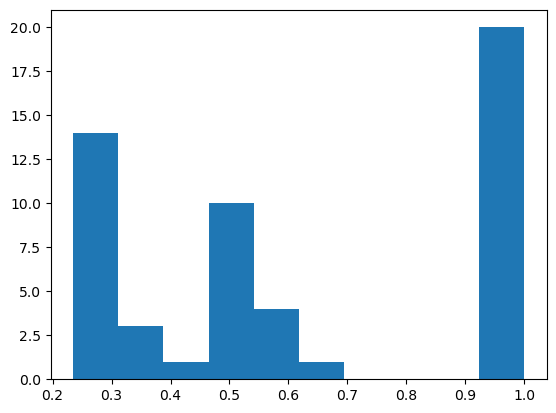

In [65]:
# Alestrus
plt.hist(pysr_df['thresholds'], bins=10)
plt.show()

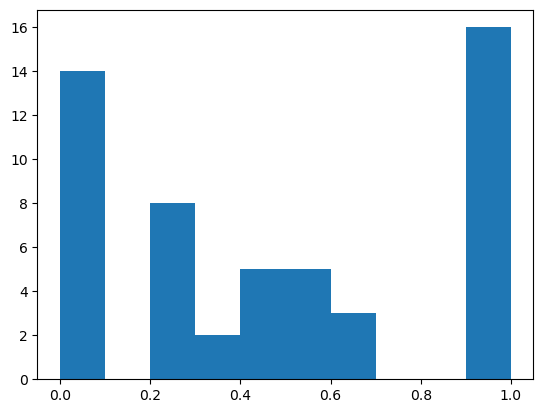

In [ ]:
# Alestrus
plt.hist(pysr_df['thresholds'], bins=10)
plt.show()

## Evaluation

In [10]:
tt = 'loo_tss'
lower_thres = -0.5
upper_thres = 1

In [11]:
linear_df['engine'] = 'Linear'
rsrm_df['engine'] = 'RSRM'
pysr_df['engine'] = 'PySR'

combined_df = pd.concat([df[df[f'{tt}']>lower_thres] for df in (linear_df, rsrm_df, pysr_df)])

# Calculate mean, standard deviation, and count
merged_df = combined_df.groupby(['complexity', 'engine'])[f'{tt}'].agg(
    mean='mean',
    std='std',
    count='count'
).reset_index()

# Calculate standard error, handling cases where count is 0
merged_df['se'] = merged_df.apply(
    lambda row: row['std'] / (row['count'] ** 0.5) if row['count'] > 0 else None,
    axis=1
)

# Rename columns for clarity
merged_df = merged_df.rename(columns={'mean': f'{tt}_mean', 'se': f'{tt}_se'})
merged_df = merged_df[merged_df[f'{tt}_mean'] < upper_thres]

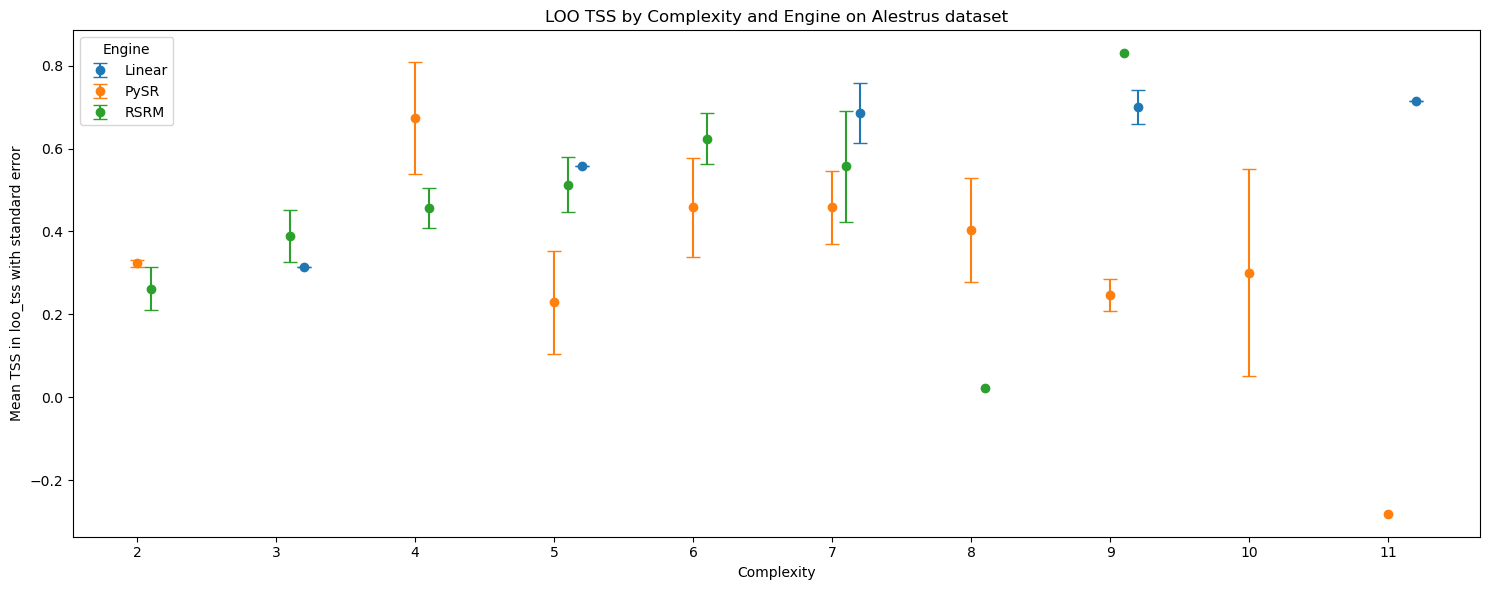

In [12]:
# Plot using scatterplot with error bars
plt.figure(figsize=(15, 6))

# Set dodge factor for error bar positions
dodge_factor = 0.1

# Assign unique offsets for each engine to dodge
engine_offsets = {
    engine: i * dodge_factor
    for i, engine in enumerate(merged_df['engine'].unique())
}
colors = plt.cm.tab10.colors

# Loop through engines to plot each group separately
for i, engine in enumerate(('Linear', 'PySR', 'RSRM')):
    subset = merged_df[merged_df['engine'] == engine]
    subset = subset[subset['complexity'] > 1]
    # Apply dodge to x positions
    x_positions = subset['complexity'] + engine_offsets[engine]
    plt.errorbar(
        x_positions,
        subset[f'{tt}_mean'],
        yerr=subset[f'{tt}_se'],
        fmt='o',  # Circle marker
        label=engine,
        capsize=5,  # Add caps to error bars
        color = colors[i]
    )

# Adjust x-ticks
plt.xticks(
    np.arange(2, merged_df['complexity'].max() + 1, 1),  # Ticks every 1 starting at 2
    fontsize=10
)

plt.title(f'LOO {metric_name.upper()} by Complexity and Engine on {dataset_name} dataset')
plt.xlabel('Complexity')
plt.ylabel(f'Mean {metric_name.upper()} in {tt} with standard error')
plt.legend(title='Engine')
plt.tight_layout()
plt.savefig(f'Plots/{dataset_name}_comparison.png', dpi=300)
plt.show()


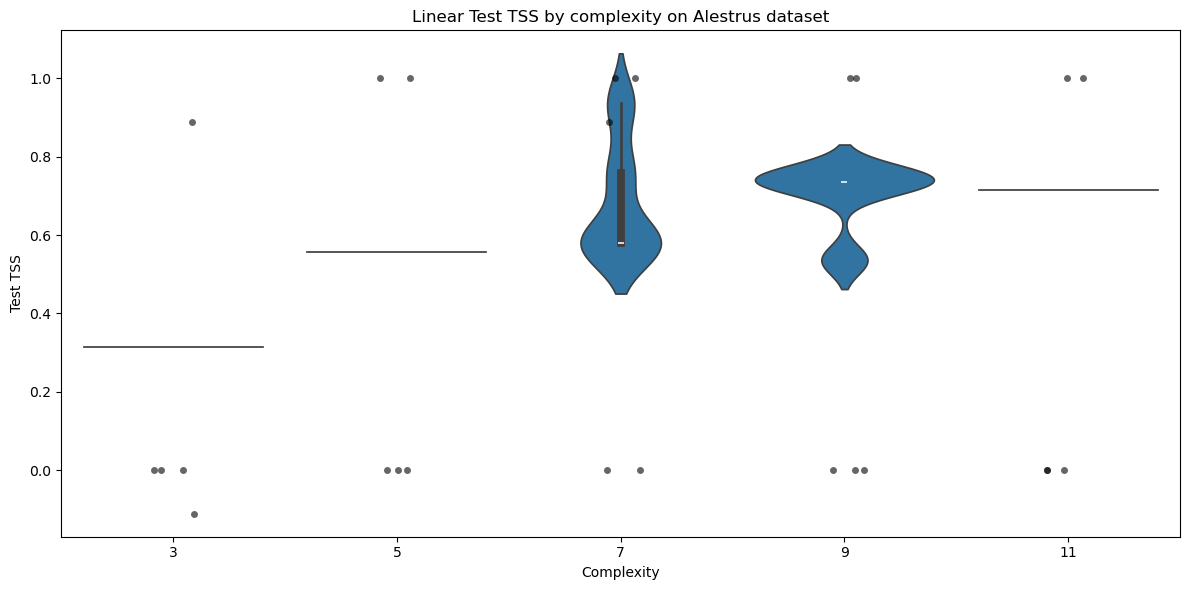

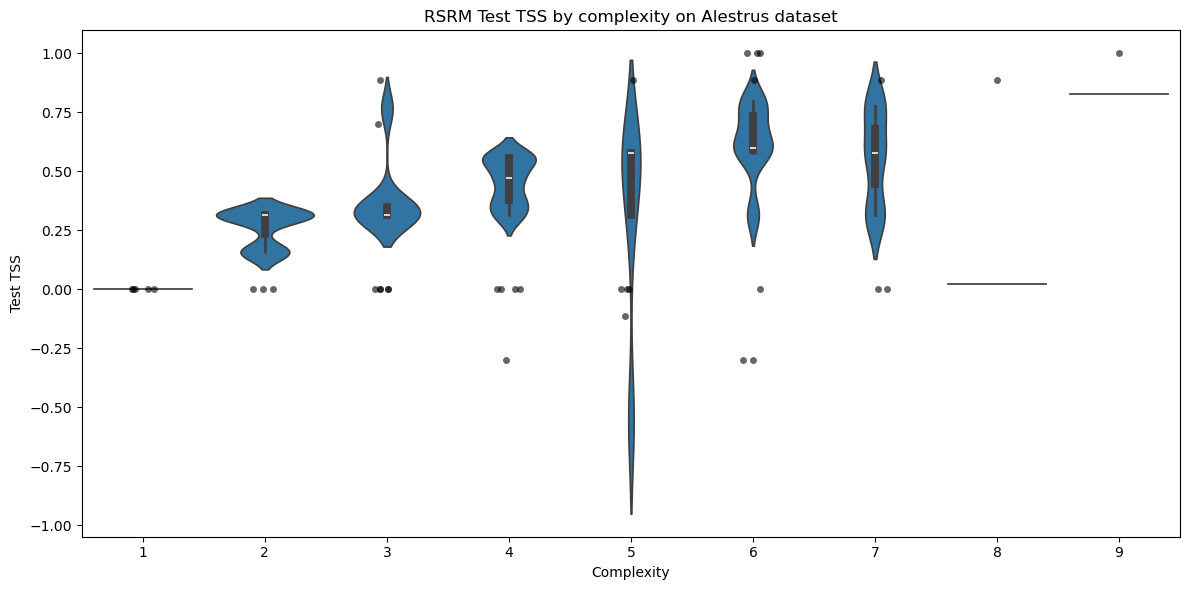

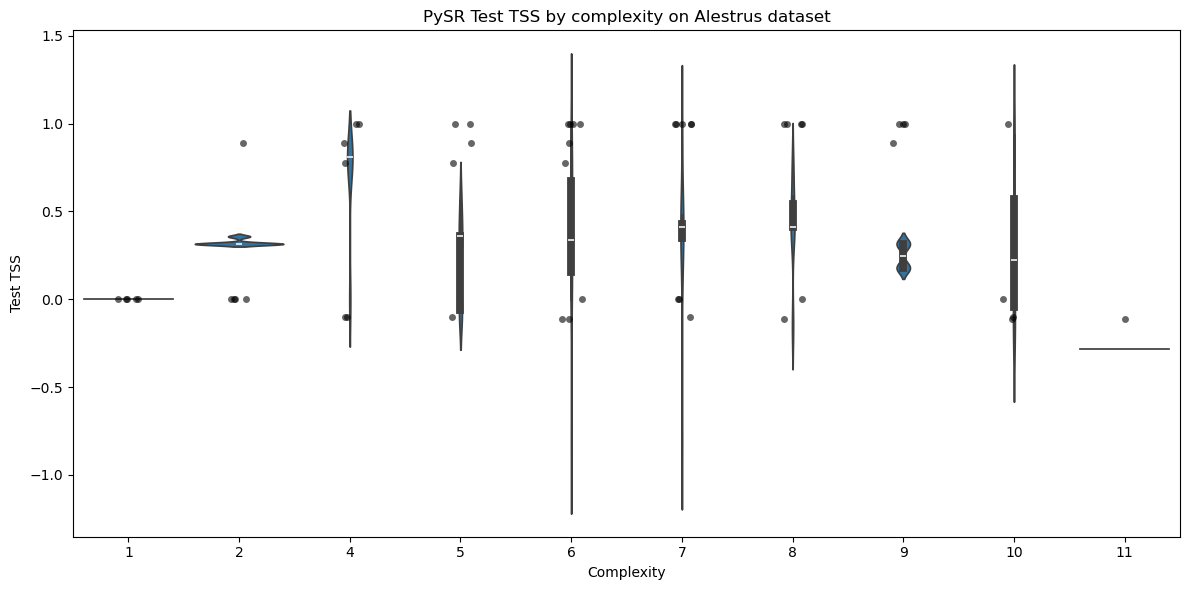

In [13]:
# Create the violin plot
for engine, df in zip(('Linear', 'RSRM', 'PySR',), (linear_df, rsrm_df[rsrm_df['test']>-1], pysr_df)):
    plt.figure(figsize=(12, 6))
    # df = df[df]
    sns.violinplot(bw_method=0.4, x='complexity', y=f'{tt}', data=df)
    sns.stripplot(x='complexity', y='test', data=df, color='k', alpha=0.6, jitter=True)
    plt.title(f'{engine} Test {metric_name.upper()} by complexity on {dataset_name} dataset')
    plt.xlabel('Complexity')
    plt.ylabel(f'Test {metric_name.upper()}')
    # plt.ylim(0,20)
    plt.tight_layout()
    plt.savefig(f'Plots/{dataset_name}_{engine}.png', dpi=300)
    plt.show()

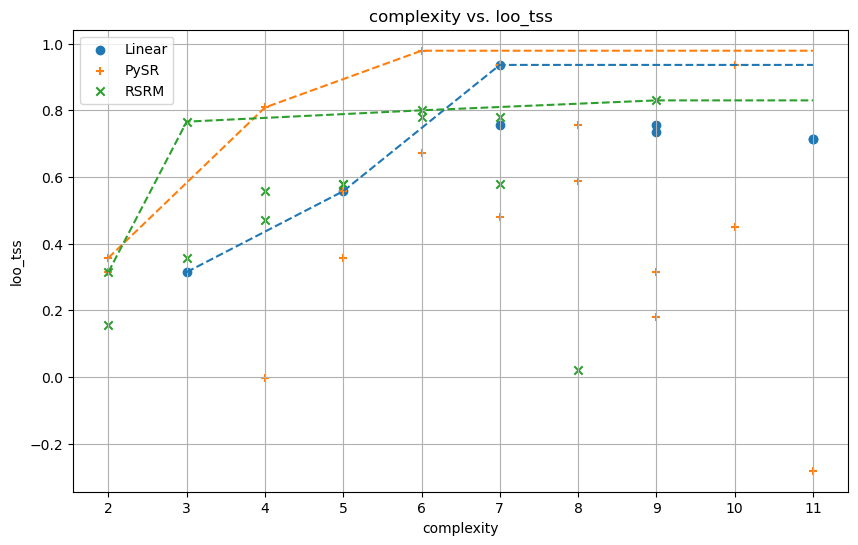

In [13]:
def transform_df(df):
    return df.sort_values(by=f'{tt}').drop_duplicates(subset='skeleton').sort_values(by=['complexity', tt], ascending=[True, not greater_is_better]).groupby('complexity').head(2).reset_index(drop=True)
def filter_df(df):
    df = df[df['complexity'] > 1]
    df = df[df[f'{tt}'] > lower_thres]
    return df

lower_thres = -1
greater_is_better = True
plot_pareto_frontier([[name, transform_df(filter_df(df))] for name, df in zip(('Linear', 'PySR', 'RSRM',), (linear_df, pysr_df, rsrm_df))], 'complexity', tt, scatter=True, minimize_y=not greater_is_better)
plt.xticks(np.arange(2, merged_df['complexity'].max() + 1, 1))
plt.show()

## Latex Reporting

In [14]:
def csv_to_latex(df, name=''):
    df = df.copy()
    # Ensure all entries in the 'Equation' column are strings
    df['equation'] = df['equation'].astype(str)
    
    df['auc'] = df['auc'].astype(float).apply(custom_round)
    df[f'{tt}'] = df[f'{tt}'].astype(float).apply(custom_round)
    
    df['equation'] = df['equation'].apply(round_constants_in_equation)
    
    # Start LaTeX table
    latex_table = "\\begin{table}[h!]\n\\centering\n\\begin{tabular}{|l|r|r|r|r|}\n\\hline\n"
    latex_table += "\\textbf{Equation} & \\textbf{Complexity} & \\textbf{" + f'{metric_name.upper()}' +"} & \\textbf{Elbow} & \\textbf{Count} \\\\\n\\hline\n"
    
    # Add rows
    for index, row in df.iterrows():
        latex_table += f"{row['equation']} & {row['complexity']} & {row[f'{tt}']} & {row['auc']} & {row['count']} \\\\\n"
    
    # End LaTeX table
    latex_table += "\\hline\n\\end{tabular}\n\\caption{Pareto Frontier with LOO evaluated" + f' {metric_name.upper()} ' + "and Elbow metric for" + f' {name} and {dataset_name} dataset' + "}\n\\label{{tab:complexity_metric_equation" + f'_{name}_{dataset_name}' + "}}\n\\end{table}"
    
    return latex_table

In [15]:
dfs=[]
for name, df in zip(('Linear', 'PySR', 'RSRM',), (linear_df, pysr_df, rsrm_df)):
    df = transform_df(df)
    all_eqs = [BernoulliEquation(eq, variables=X.columns.tolist()) for eq in df['equation']]
    for eq in all_eqs:
        eq.fit(normalize_by_iqr(np.asarray(X)), np.asarray(y))
    df['equation'] = [eq.get_fitted_equation_string() for eq in all_eqs]
    df['threshold'] = [eq.threshold for eq in all_eqs]
    df = compute_pareto_frontier(df, 'complexity', tt, minimize_y=not greater_is_better)
    df = compute_elbow_metric(df, 'complexity', tt, maximize_tt=greater_is_better)
    df['auc'] = df['elbow_metric']
    print(csv_to_latex(df[['equation', 'complexity', 'auc', 'count', f'{tt}']], name))
    print('\n')
df = pd.concat([linear_df, rsrm_df, pysr_df], ignore_index=True)
df = transform_df(df)
all_eqs = [BernoulliEquation(eq, variables=X.columns.tolist()) for eq in df['equation']]
for eq in all_eqs:
    eq.fit(normalize_by_iqr(np.asarray(X)), np.asarray(y))
df['equation'] = [eq.get_fitted_equation_string() for eq in all_eqs]
df['threshold'] = [eq.threshold for eq in all_eqs]
df = compute_pareto_frontier(df, 'complexity', tt, minimize_y=not greater_is_better)
df = compute_elbow_metric(df, 'complexity', tt, maximize_tt=greater_is_better)
df['auc'] = df['elbow_metric']
df['count'] = [all_counts[s] for s in df['skeleton']]
print(csv_to_latex(df[['equation', 'complexity', 'auc', 'count', f'{tt}']], 'All'))

\begin{table}[h!]
\centering
\begin{tabular}{|l|r|r|r|r|}
\hline
\textbf{Equation} & \textbf{Complexity} & \textbf{TSS} & \textbf{Elbow} & \textbf{Count} \\
\hline
3.26 - 6.34*D & 3 & 0.31 & nan & 5 \\
30.87*H - 20.38*P - 6.34 & 5 & 0.56 & 6.81e-02 & 5 \\
2799.53*H - 1156.87*P + 1322.25*T - 11192.2 & 7 & 0.94 & -1.89e-01 & 1 \\
\hline
\end{tabular}
\caption{Pareto Frontier with LOO evaluated TSS and Elbow metric for Linear and Alestrus dataset}
\label{{tab:complexity_metric_equation_Linear_Alestrus}}
\end{table}


\begin{table}[h!]
\centering
\begin{tabular}{|l|r|r|r|r|}
\hline
\textbf{Equation} & \textbf{Complexity} & \textbf{TSS} & \textbf{Elbow} & \textbf{Count} \\
\hline
-2.24e+00 & 1 & 0 & nan & 5 \\
4.89 - T & 2 & 0.36 & -1.32e-01 & 1 \\
cond(2.33 - H, -2.71e+00) & 4 & 0.81 & -1.40e-01 & 5 \\
-2.95e+03*1.3**P + 2953.8*H & 6 & 0.98 & -8.51e-02 & 1 \\
\hline
\end{tabular}
\caption{Pareto Frontier with LOO evaluated TSS and Elbow metric for PySR and Alestrus dataset}
\label{{tab:com

# Experiments

In [10]:
equations_to_test = ['0.65 - 1*D', '1.04 - 1*(D)**2', '1.4 - 1*(D)**(D)']
lls = lambdify_equations(equations_to_test, variables=X.columns.tolist())
use_glm = False
basinhop = False

scores_train = [list() for i in range(len(equations_to_test))]
scores_tss_threshold = []
scores_tss = []
scores_bce = []
thresholds = [list() for i in range(len(equations_to_test))]
for eq_str in equations_to_test:
    eq_skel = replace_numeric_parameters(eq_str)
    original_params = extract_numeric_parameters(eq_str)
    print('Assessing ', eq_skel)
    loo = LeaveOneOut()
    initial_guess = original_params
    probas_preds = []
    binary_preds = []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        X_train_s = normalize_by_iqr(X_train)
        X_test_s = normalize_by_iqr(X_test, X_train)

        # Optimize equation and get parameters (Cs)
        Cs, min = optimize_equation(eq_skel, X_train_s, y_train, variables=X.columns.tolist(), loss=loss, initial_guess=original_params, basinhop=basinhop, use_glm=use_glm)
        eqstr_params = replace_optimized_parameters(eq_skel, Cs)
        ll = lambdify_equations([eqstr_params], variables=X.columns.tolist())[0]
        threshold = get_threshold(ll, np.asarray(X_train_s), np.asarray(y_train))
        thresholds[equations_to_test.index(eq_str)].append(threshold)

        scores_train[equations_to_test.index(eq_str)].append(binary_cross_entropy(y_train, sigmoid(ll(X_train_s))))

        y_pred = ll(X_test_s)
        probas_preds.append(y_pred.item())
        if not regression:
            if key != 'linear':
                y_pred = sigmoid(y_pred)
            y_pred = binarize_predictions(y_pred, threshold=threshold)
            binary_preds.append(y_pred.item())

    probas_preds = np.array(probas_preds)
    binary_preds = np.array(binary_preds)
    val = binary_cross_entropy(y, sigmoid(probas_preds))
    scores_bce.append(val)
    scores_tss.append(true_skill_statistic(y, binarize_predictions(sigmoid(probas_preds))))
    scores_tss_threshold.append(true_skill_statistic(y, binary_preds))

print("bce (train): ", np.mean(scores_train, axis=1))
print("bce (test): ", scores_bce)
print("tss: ", scores_tss)
print("tss (adjusting threshold): ", scores_tss_threshold)
print("Mean threshold: ", np.mean(thresholds, axis=1))

Assessing  C - C*D
Assessing  C - C*(D)**C
Assessing  C - C*(D)**(D)
bce (train):  [0.43504289 0.42811471 0.42766084]
bce (test):  [0.4734933971376544, 0.49173601755479823, 0.4715902937950205]
tss:  [0.4378378378378378, 0.38378378378378386, 0.38378378378378386]
tss (adjusting threshold):  [0.5567567567567568, 0.5567567567567568, 0.5567567567567568]
Mean threshold:  [0.24936384 0.32972225 0.33817504]


In [12]:
equations_to_test = ['0.65 - 1*D', '1.04 - (1*D)**2', '1.4 - (D)**(D)']
lls = lambdify_equations(equations_to_test, variables=X.columns.tolist())
use_glm = False
basinhop = False

scores_train = [list() for i in range(len(equations_to_test))]
scores_tss_threshold = []
scores_tss = []
scores_bce = []
thresholds = [list() for i in range(len(equations_to_test))]
for eq_str in equations_to_test:
    equation = BernoulliEquation(eq_str, X.columns.tolist(), use_glm)
    print('Assessing ', equation)
    loo = LeaveOneOut()
    probas_preds = []
    binary_preds = []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        X_train_s = normalize_by_iqr(X_train)
        X_test_s = normalize_by_iqr(X_test, X_train)

        # Optimize equation and get parameters (Cs)
        equation.fit(np.asarray(X_train_s), np.asarray(y_train), basinhop=basinhop)

        threshold = equation.threshold
        thresholds[equations_to_test.index(eq_str)].append(threshold)

        scores_train[equations_to_test.index(eq_str)].append(binary_cross_entropy(y_train, equation.predict_probas(X_train_s)))

        y_pred = equation.predict_probas(X_test_s)
        probas_preds.append(y_pred.item())
        # Binary predictions using the learned threshold   
        y_pred = equation.predict(X_test_s)
        binary_preds.append(y_pred.item())

    probas_preds = np.array(probas_preds)
    binary_preds = np.array(binary_preds)
    val = binary_cross_entropy(y, probas_preds)
    scores_bce.append(val)
    scores_tss.append(true_skill_statistic(y, binarize_predictions(probas_preds)))
    scores_tss_threshold.append(true_skill_statistic(y, binary_preds))

print("bce (train): ", np.mean(scores_train, axis=1))
print("bce (test): ", scores_bce)
print("tss (default threshold): ", scores_tss)
print("tss (learned threshold): ", scores_tss_threshold)
print("Mean threshold: ", np.mean(thresholds, axis=1))

Assessing  C - C*D
Assessing  C - (C*D)**C
Assessing  C - (D)**(D)
bce (train):  [0.43504289 0.42811471 0.444925  ]
bce (test):  [0.4734933971376544, 0.49173603029540175, 0.4623730612269451]
tss (default threshold):  [0.4378378378378378, 0.38378378378378386, 0.2648648648648648]
tss (learned threshold):  [0.4504504504504503, 0.5171171171171172, 0.6504504504504505]
Mean threshold:  [0.28063717 0.33978159 0.36176455]


In [38]:
for ll in lls:
    print(binarize_predictions(sigmoid(ll(X.sort_values('D')))))

[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
